<img src="./logo_UTN.svg" align="right" width="150" /> 

#### Análisis y Procesamiento de Señales

# Trabajo Práctico Nº5: Filtrado digital lineal de ECG
#### Ariel Hipolito


# Introducción

Usando el archivo **ecg.mat** que contiene un registro electrocardiográfico (*ECG*) registrado durante una prueba de esfuerzo, junto con una serie de variables descriptas a continuación. Diseñe y aplique los filtros digitales necesarios para mitigar las siguientes fuentes de contaminación:

- Ruido causado por el movimiento de los electrodos (Alta frecuencia).
- Ruido muscular (Alta frecuencia).
- Movimiento de la línea de base del ECG, inducido en parte por la respiración (Baja frecuencia).

*Ayuda: Los detalles de cómo acceder a ecg.mat los pueden encontrar en ***lectura_sigs.py****

Archivo ECG.mat (variables):*


- **ecg_lead**: Registro de ECG muestreado a f s igual 1  KHz durante una prueba de esfuerzo
- **qrs_pattern1**: Complejo de ondas QRS normal
- **heartbeat_pattern1**: Latido normal
- **heartbeat_pattern2**: Latido de origen ventricular
- **qrs_detections**: vector con las localizaciones (en # de muestras) donde ocurren los latidos

---

## LIBRERIAS: 


In [2]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal as sig
import scipy.io as sio
import pandas as pd
from scipy.io import wavfile
from pydub import AudioSegment
from scipy.signal import remez, welch, firwin, filtfilt, iirdesign, freqz_sos, sosfiltfilt, sos2tf, tf2zpk, firwin2, freqz, firls, lfilter

## SEÑAL ECG:

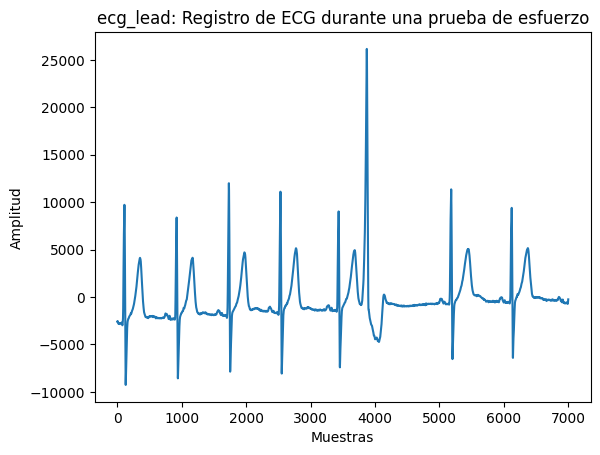

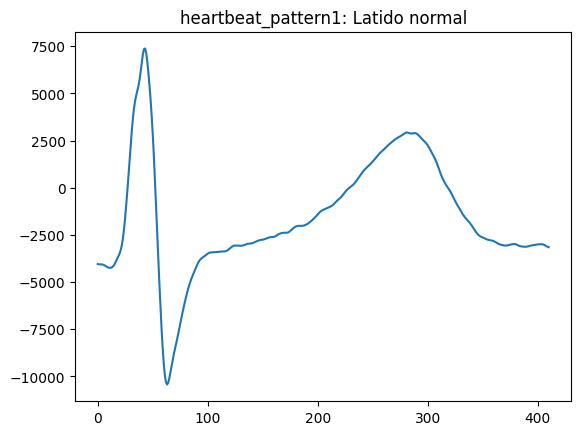

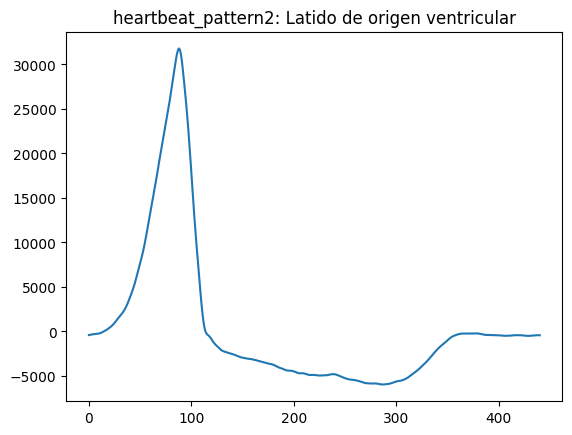

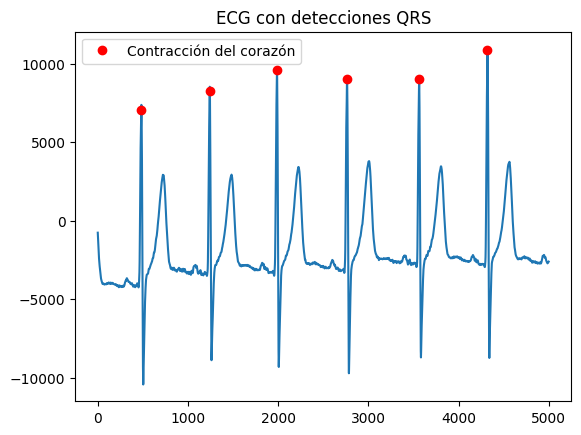

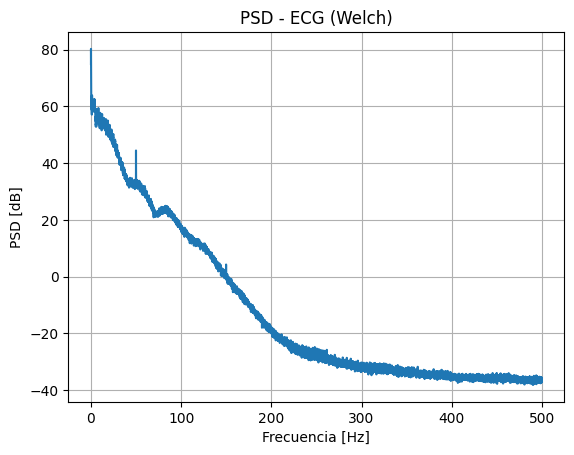

In [3]:
#%% LECTURA DE SEÑALES

# ECG
fs_ecg = 1000  # Hz

# para listar las variables que hay en el archivo
sio.whosmat('ECG_TP4.mat')
mat_struct = sio.loadmat('./ECG_TP4.mat')

#.squeeze() elimina dimensiones de tamaño 1 (por ejemplo, convierte (1, N) o (N, 1) en (N,)).
ecg_one_lead = mat_struct['ecg_lead'].squeeze()
N = len(ecg_one_lead)

# Latido normal: para analizar morfología de un latido tipico
hb_1 = mat_struct['heartbeat_pattern1']

# Latido ventricular (anormal): Latido patológico, como una extrasístole ventricular.
hb_2 = mat_struct['heartbeat_pattern2']

#Entrenamiento de clasificadores o algoritmos de detección:
#plantilla para detección de latidos (cross-correlation, matched filter).
qrs_pat = mat_struct['qrs_pattern1'] 

#Comparar latidos normales y anormales:
# - Marcar los latidos en la señal ecg_lead.
# - Extraer cada latido para análisis automático.
# - Calcular intervalos RR (tiempo entre latidos) → frecuencia cardíaca.
qrs_detect = mat_struct['qrs_detections'] # Vector con las posiciones (índices de muestra) donde se detectaron complejos QRS en ecg_lead

#GRAFICAMOS: 

plt.figure()
plt.title("ecg_lead: Registro de ECG durante una prueba de esfuerzo")
plt.xlabel("Muestras"); plt.ylabel("Amplitud")
plt.plot(ecg_one_lead[5000:12000]) # 6 segundos

plt.figure()
plt.title("heartbeat_pattern1: Latido normal")
plt.plot(hb_1)

plt.figure()
plt.title("heartbeat_pattern2: Latido de origen ventricular")
plt.plot(hb_2)

plt.figure()
plt.plot(ecg_one_lead[0:5000])
plt.plot(qrs_detect[qrs_detect < 5000], ecg_one_lead[qrs_detect[qrs_detect < 5000]], 'ro', label='Contracción del corazón')
plt.title("ECG con detecciones QRS")
plt.legend()

'''Los complejos QRS son una de las partes más importantes de la señal de ECG (electrocardiograma), 
y representan la despolarización de los ventrículos, es decir, el momento en que el corazón se contrae para bombear sangre.'''

ff_ecg, psd_ecg = sig.welch(ecg_one_lead, fs=fs_ecg, window='hann', nperseg = N//40)
psd_ecg_db = 10 * np.log10(psd_ecg)

plt.figure()
plt.plot(ff_ecg, psd_ecg_db)
plt.title("PSD - ECG (Welch)")
plt.xlabel("Frecuencia [Hz]"); plt.ylabel("PSD [dB]")
plt.grid(True)

nyq = fs_ecg / 2.0

## PARAMETROS DE INTERES:

Atraves de la observación de la señal ECG del trabajo anterior definiremos las frecuencias criticas. 

In [4]:
nyq = fs_ecg / 2.0

# Especificaciones: divido por dos porque voy a pasar 2 veces por el filtro

ripple = 1/2  # dB de rizado en banda pasante
atenuacion = 40/2 # dB de atenuación mínima en banda de stop

# Frecuencias críticas (Hz):

ws1 = 0.1   # stopband inferior
wp1 = 0.8   # passband inferior
wp2 = 35.0  # passband superior
ws2 = 40.0  # stopband superior

# Normalización (a Nyquist)
wp = [wp1/nyq, wp2/nyq]
ws = [ws1/nyq, ws2/nyq]

En el procesamiento digital de señales, los filtros permiten modificar el contenido espectral de una señal para eliminar interferencias y preservar la información relevante. Existen dos familias fundamentales: **Filtros IIR** (Infinite Impulse Response) y **Filtros FIR** (Finite Impulse Response).

En señales biomedicas es fundamental:
- No introducir ripple en la banda pasante: afecta la amplitud del electrocardiograma.  
- Tener una transición relativamente rápida: dado que la banda util del electrocardiograma (0.8 - 35 Hz) está muy cerca del ruido de baja y alta.
- Lograr una fuerte atenuación en alta frecuencia: para eliminar ruido muscular.

En aplicaciones como el ECG, la elección entre FIR e IIR depende del compromiso entre preservación de la morfología (FIR) y eficiencia con alta selectividad (IIR).

## FILTROS IIR (Infinite Impulse Response)
Los filtros IIR tienen una respuesta al impulso infinita debido al uso de realimentación. Se caracterizan por:

- Lograr **alta selectividad con órdenes bajos**.
- No poseer fase lineal, pudiendo generar **distorsión temporal**.
- Tener **estabilidad condicionada** a la ubicación de los polos.
- Diseñarse mediante aproximaciones clásicas como **Butterworth**, **Chebyshev I**, **Chebyshev II** y **Cauer (Elíptico)**.

### DISEÑO FILTROS:

In [5]:
#Aprox modulo: 
f_aprox = ['butter', 'cheby1', 'cheby2', 'cauer']

# Diseño con iirdesign
sos_butter = iirdesign(
    wp=wp, ws=ws,
    gpass=ripple, gstop=atenuacion,
    analog=False,
    ftype= f_aprox[0],
    output='sos'
)

sos_cheby1 = iirdesign(
    wp=wp, ws=ws,
    gpass=ripple, gstop=atenuacion,
    analog=False,
    ftype= f_aprox[1],
    output='sos'
)

sos_cheby2 = iirdesign(
    wp=wp, ws=ws,
    gpass=ripple, gstop=atenuacion,
    analog=False,
    ftype= f_aprox[2],
    output='sos'
)

sos_cauer = iirdesign(
    wp=wp, ws=ws,
    gpass=ripple, gstop=atenuacion,
    analog=False,
    ftype= f_aprox[3],
    output='sos'
)

w_butter, h_butter = freqz_sos(sos_butter, worN=np.logspace(-2, 1.9, 1000), fs=fs_ecg)
h_but_db = 20 * np.log10(np.abs(h_butter))

w_ch1, h_ch1 = freqz_sos(sos_cheby1, worN=np.logspace(-2, 1.9, 1000), fs=fs_ecg)
h_ch1_db = 20 * np.log10(np.abs(h_ch1))

w_ch2, h_ch2 = freqz_sos(sos_cheby2, worN=np.logspace(-2, 1.9, 1000), fs=fs_ecg)
h_ch2_db = 20 * np.log10(np.abs(h_ch2))

w_cauer, h_cauer = freqz_sos(sos_cauer, worN=np.logspace(-2, 1.9, 1000), fs=fs_ecg)
h_cauer_db = 20 * np.log10(np.abs(h_cauer))

### VALIDACION CON PLANTILLA:

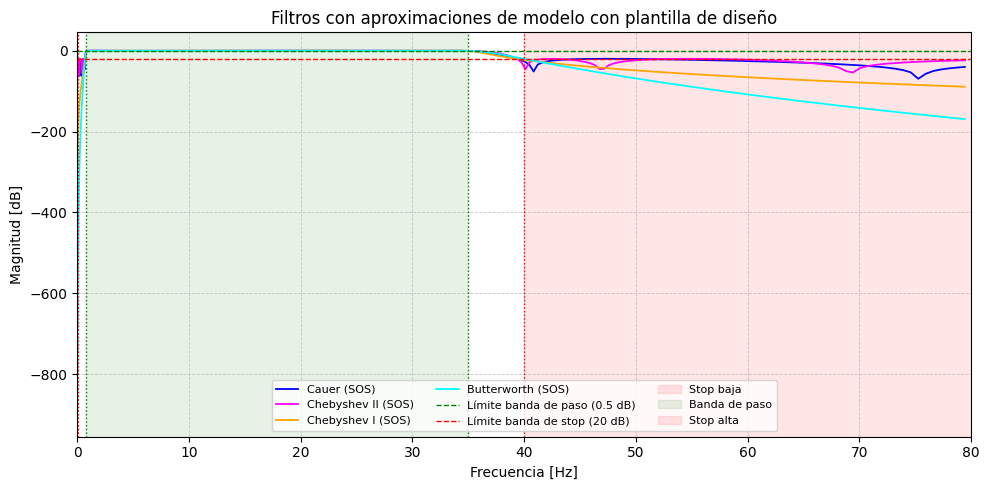

In [6]:
#%% VISUALIZACIÓN: Filtros con plantilla de diseño iir
plt.figure(figsize=(10, 5))

# Curva del filtro
plt.plot(w_cauer, h_cauer_db, color='blue',    linewidth=1.3, label='Cauer (SOS)')
plt.plot(w_ch2, h_ch2_db, color='magenta', linewidth=1.3, label='Chebyshev II (SOS)')
plt.plot(w_ch1, h_ch1_db, color='orange',  linewidth=1.3, label='Chebyshev I (SOS)')
plt.plot(w_butter, h_but_db, color='cyan',    linewidth=1.3, label='Butterworth (SOS)')

# Líneas horizontales de la plantilla
plt.axhline(-ripple, color='green', linestyle='--', linewidth=1, label='Límite banda de paso (0.5 dB)')
plt.axhline(-atenuacion, color='red', linestyle='--', linewidth=1, label='Límite banda de stop (20 dB)')

# Bandas coloreadas
plt.axvspan(0, ws1, color='red', alpha=0.1, label='Stop baja')
plt.axvspan(wp1, wp2, color='green', alpha=0.1, label='Banda de paso')
plt.axvspan(ws2, nyq, color='red', alpha=0.1, label='Stop alta')

# Líneas verticales punteadas
plt.axvline(ws1, color='r', linestyle=':', linewidth=1)
plt.axvline(wp1, color='g', linestyle=':', linewidth=1)
plt.axvline(wp2, color='g', linestyle=':', linewidth=1)
plt.axvline(ws2, color='r', linestyle=':', linewidth=1)

# Ejes y estética
plt.title('Filtros con aproximaciones de modelo con plantilla de diseño', fontsize=12)
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('Magnitud [dB]')
plt.xlim(0, 80)
plt.grid(True, which='both', linestyle='--', linewidth=0.6, alpha=0.7)
plt.legend(loc='lower center', ncol=3, fontsize=8)
plt.tight_layout()
plt.show()

### FILTRADO DE ECG RUIDOSA 

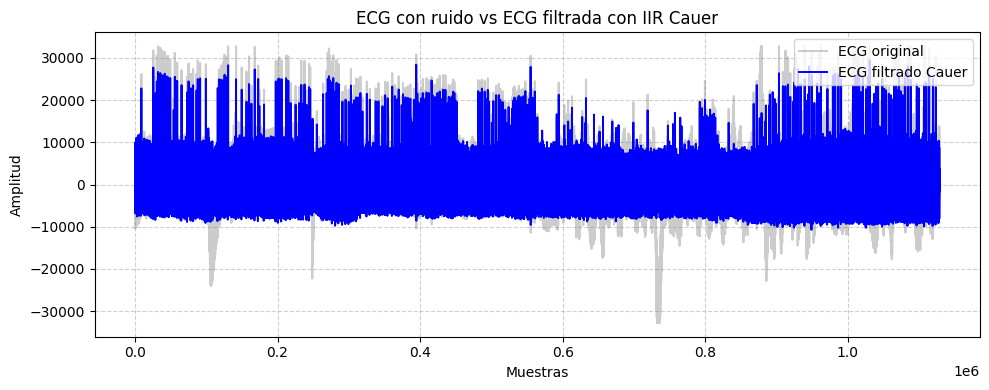

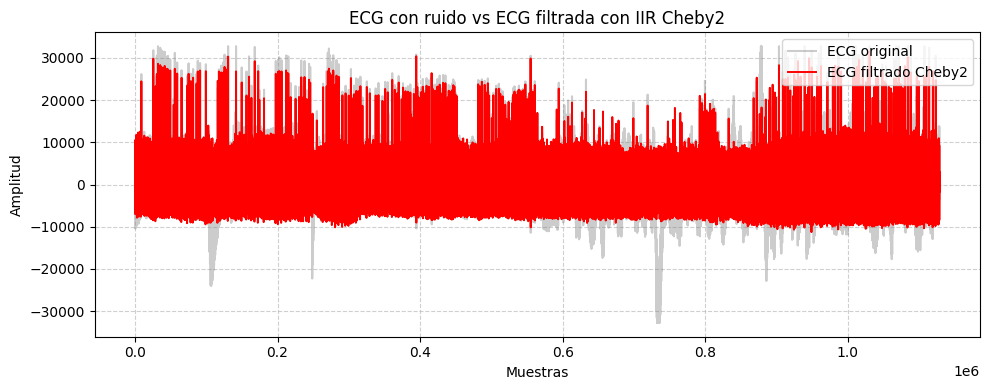

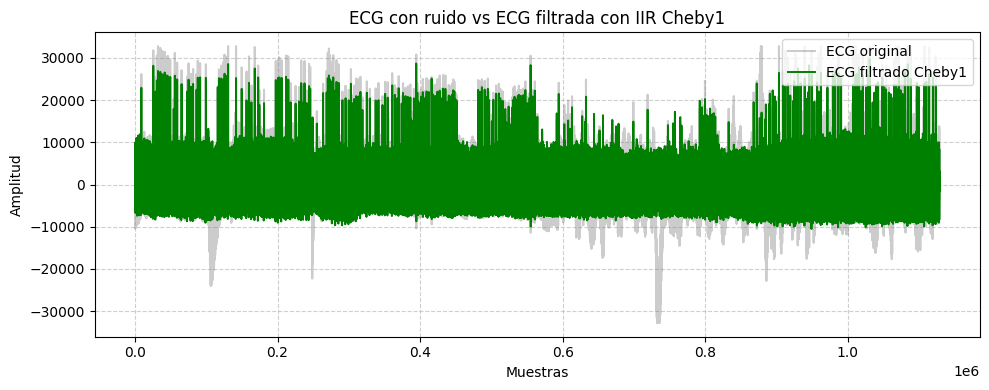

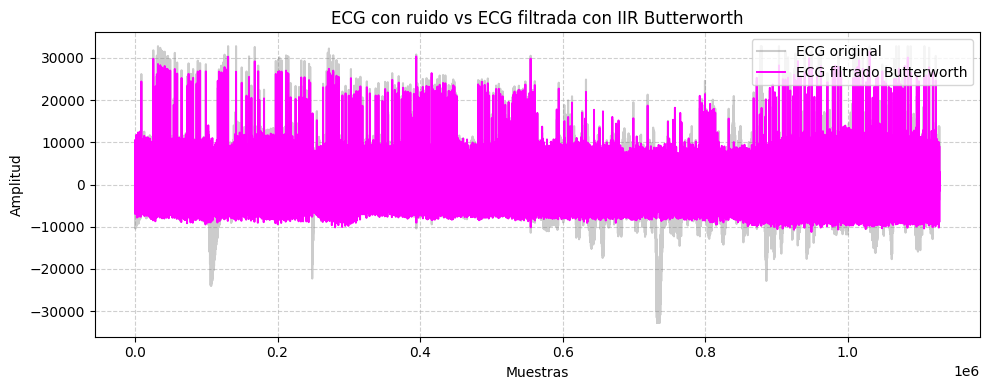

In [7]:
#%% IMPLEMENTACION FILTROS IIR 

ecg_filt_cauer = sosfiltfilt(sos_cauer, ecg_one_lead)
ecg_filt_cheby2 = sosfiltfilt(sos_cheby2, ecg_one_lead)
ecg_filt_cheby1 = sosfiltfilt(sos_cheby1, ecg_one_lead)
ecg_filt_butter = sosfiltfilt(sos_butter, ecg_one_lead)

#%% COMPARACION FILTROS IIR: 
plt.figure(figsize=(10,4))
plt.plot(ecg_one_lead, color='gray', alpha=0.4, label='ECG original')
plt.plot(ecg_filt_cauer, color='blue',  linewidth=1.4, label='ECG filtrado Cauer')
plt.title('ECG con ruido vs ECG filtrada con IIR Cauer')
plt.xlabel('Muestras')
plt.ylabel('Amplitud')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(loc='upper right')
plt.tight_layout()

plt.figure(figsize=(10,4))
plt.plot(ecg_one_lead, color='gray', alpha=0.4, label='ECG original')
plt.plot(ecg_filt_cheby2, color='red', linewidth=1.4, label='ECG filtrado Cheby2')
plt.title('ECG con ruido vs ECG filtrada con IIR Cheby2')
plt.xlabel('Muestras')
plt.ylabel('Amplitud')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(loc='upper right')
plt.tight_layout()

plt.figure(figsize=(10,4))
plt.plot(ecg_one_lead, color='gray', alpha=0.4, label='ECG original')
plt.plot(ecg_filt_cheby1, color='green',  linewidth=1.4, label='ECG filtrado Cheby1')
plt.title('ECG con ruido vs ECG filtrada con IIR Cheby1')
plt.xlabel('Muestras')
plt.ylabel('Amplitud')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(loc='upper right')
plt.tight_layout()

plt.figure(figsize=(10,4))
plt.plot(ecg_one_lead, color='gray', alpha=0.4, label='ECG original')
plt.plot(ecg_filt_butter, color='magenta',  linewidth=1.4, label='ECG filtrado Butterworth')
plt.title('ECG con ruido vs ECG filtrada con IIR Butterworth')
plt.xlabel('Muestras')
plt.ylabel('Amplitud')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(loc='upper right')
plt.tight_layout()

A partir del análisis teórico (Holton, *Digital Signal Processing: Principles and Applications*, 2021) y de los resultados experimentales obtenidos sobre el registro ECG provisto, se concluye lo siguiente:

### **1) Filtro Butterworth**

La aproximación Butterworth posee un módulo absolutamente plano en la banda pasante.  
Sin embargo, presenta limitaciones importantes para el caso del ECG:

- **Baja selectividad**.
- Para cumplir la plantilla (rechazo fuerte por encima de 40 Hz y por debajo de ~0.8 Hz) requiere **órdenes muy altos**.
- Órdenes altos implican:
  - mayor tiempo de cómputo,
  - mayor distorsión de fase (incluso aplicando `filtfilt`),
  - posible **pérdida de contenido útil** del QRS.

Por lo tanto, aunque sirve como referencia, **no es la aproximación óptima para ECG**.

### **2) Chebyshev Tipo I (Cheby1)**

La aproximación Chebyshev I mejora la selectividad respecto de Butterworth, pero introduce **ripple en banda pasante**.

Cualquier variación dentro de la banda útil puede alterar la amplitud relativa de:

- las ondas P,
- el complejo QRS,
- la onda T.

Esto afecta la interpretación clínica del trazado.  
Por esa razón, a pesar de su mejor selectividad, **no es ideal para señales biomédicas**.

### **3) Chebyshev Tipo II (Cheby2)**

El Chebyshev II elimina el ripple en banda pasante y concentra las oscilaciones en la banda de rechazo.

Ventajas principales:

- **No altera la amplitud del QRS**.
- Muy buena **selectividad**.
- Cumple la plantilla con un **orden moderado**.
- Atenúa eficazmente:
  - ruido muscular (>40 Hz),
  - movimiento de línea de base (<0.8 Hz).

En las pruebas realizadas, **preservó correctamente la morfología** del ECG mientras mitigó las interferencias.

### **4) Cauer**

El filtro Cauer es el de **mayor selectividad** entre las aproximaciones clásicas.

- **Transiciones extremadamente rápidas**.
- Excelente atenuación en ambas bandas de rechazo.
- Cumplimiento estricto de la plantilla con el **orden más bajo posible**.
- Banda pasante estable y con **mínima distorsión**.

Esta aproximación es la adecuada cuando se deben definir de forma precisa las bandas, como en ECG.  

En nuestras simulaciones, el filtro Cauer fue el que **mejor desempeño mostró**:

- preservó fielmente la morfología del QRS,
- eliminó el ruido muscular (>40 Hz),
- eliminó el movimiento de la línea de base (<0.8 Hz).


## FILTROS FIR (Finite Impulse Response)
Los filtros FIR poseen una respuesta al impulso de duración finita. Su salida depende únicamente de un número limitado de muestras pasadas. Sus principales características son:

- Son siempre **estables**.
- Permiten diseñar **fase lineal**, preservando la forma de onda.
- Requieren **órdenes altos** para lograr transiciones estrechas.
- Se diseñan mediante técnicas como **ventanas**, **mínimos cuadrados** o **Parks–McClellan (Remez)**.

---

### METODO DE VENTANEO: 
El diseño por ventaneo consiste en partir de la respuesta ideal en frecuencia del filtro y multiplicarla por una ventana temporal que controle el comportamiento del lóbulo principal y de los lóbulos secundarios. Cada ventana establece un compromiso diferente entre **resolución en frecuencia**, **nivel de atenuación** y **ripple**.

En el trabajo practico anterior se analizaron en detalle diversas ventanas —Rectangular, Hann, Hamming, Blackman–Harris y Flattop— evaluando su impacto sobre el *leakage* y la precisión en la estimación de amplitud. A partir de esos resultados, y considerando los requisitos específicos del procesamiento de ECG, la **ventana Hamming** se selecciona como la opción más adecuada para el diseño del filtro FIR.

Las razones principales son:

- **Ripple pasante reducido**: la ventana Hamming minimiza oscilaciones dentro de la banda útil, lo cual es clave para preservar la morfología de ondas de baja amplitud como P y T.
- **Atenuación lateral suficientemente alta** (≈ 50–55 dB): permite suprimir de manera efectiva el ruido muscular (>40 Hz) sin necesidad de aumentar excesivamente el orden del filtro.
- **Ancho de transición moderado**: evita suavizar demasiado las pendientes pronunciadas del complejo QRS, manteniendo su forma característica.
- **Buen compromiso entre resolución y suavidad**: si bien ventanas como Blackman–Harris o Flattop ofrecen mayor atenuación, su costo en resolución espectral puede afectar la definición temporal del ECG; Hamming logra un balance más adecuado.

En síntesis, la ventana Hamming funciona como un **punto intermedio óptimo**: reduce *leakage* de forma importante, atenúa suficientemente el ruido y conserva la morfología del ECG, sin incurrir en la pérdida de resolución que implican ventanas más agresivas.

---

### MÉTODO DE MÍNIMOS CUADRADOS:

El método de **mínimos cuadrados** diseña el FIR buscando que la respuesta en frecuencia del filtro sea lo más parecida posible (en promedio) a una respuesta ideal especificada.

A diferencia del ventaneo —que parte de un ideal y lo atenúa multiplicándolo por una ventana— firls **optimiza directamente la amplitud** minimizando el error cuadrático entre la respuesta real del filtro y a plantilla deseada (baja frecuencia → 0, banda útil → 1, alta frecuencia → 0).

Sus características principales:

- Ofrece **excelente control del error promedio** dentro de cada banda.
- Produce transiciones más suaves y con menos oscilaciones que ventanas simples.
- No genera ripple pasante significativo (a diferencia de Chebyshev I).
- No es tan selectivo como Parks–McClellan, pero suele generar filtros más “suaves”, ideales para señales biomédicas.

En el contexto del ECG, el método de mínimos cuadrados resulta útil porque:

- Minimiza errores globales sin introducir ondulaciones fuertes en la banda útil.
- Ofrece un filtrado suave y controlado, preservando la morfología del complejo QRS.
- Cumple adecuadamente la plantilla cuando se ajustan correctamente las frecuencias de transición.

Por lo tanto, **firls complementa al método de ventaneo**, permitiendo un diseño FIR más flexible y matemáticamente optimizado para la respuesta deseada del ECG.

## MÉTODO DE PARKS–McCLELLAN (REMEZ)

El algoritmo se basa en la teoría de **aproximación de Chebyshev**, donde la solución óptima es aquella que hace que el error entre la respuesta deseada e implementada:

- oscile de forma alternada (“**equiripple**”),
- alcance el mismo valor máximo positivo y negativo,
- cumpla con la plantilla usando el mínimo orden posible.

En otras palabras, Parks–McClellan diseña **el FIR “más corto” que puede cumplir la plantilla**, para un conjunto dado de bandas y pesos.

Sus características principales

- **Equiripple garantizado**: produce el menor ripple posible que aún cumpla la especificación, distribuyéndolo uniformemente.
- **Máxima selectividad por coeficiente**: logra transiciones mucho más abruptas que ventanas o mínimos cuadrados para el mismo orden.
- **Control explícito del peso entre bandas**: permite exigir mayor atenuación en la banda baja o alta sin incrementar innecesariamente el ripple pasante.
- **Ideal para plantillas exigentes**: cuando la transición debe ser muy estrecha (p. ej., separar ruido muscular sin deformar el QRS), Parks–McClellan es el FIR más eficiente.
- **Óptimo para filtros ECG cuando se requiere fase estrictamente lineal**:  
  — Cumple la plantilla con el menor orden posible.  
  — Mantiene la fase lineal exacta (propia de FIR).  
  — Evita la pérdida de detalle que ocurre con FIR-LS en ruido fuerte.

En este contexto, el método Remez permite:

- Obtener un FIR **mucho más selectivo** que ventanas (Hamming) y mínimos cuadrados.  
- Mantener ripple pasante muy bajo, preservando la morfología del QRS.  
- Controlar de forma precisa las atenuaciones en ambas bandas de stop (ruido de baja frecuencia / movimiento + ruido muscular).  
- Reducir el orden del FIR manteniendo fase perfectamente lineal, algo valioso para análisis de intervalos y detección de arritmias.

El algoritmo de **Parks–McClellan**, implementado en `scipy.signal.remez`, diseña filtros FIR óptimos en el sentido **minimax**.  
A diferencia del ventaneo (que controla indirectamente el ripple) y del método de mínimos cuadrados (que minimiza el error promedio), **Remez minimiza el error máximo (∞-norm)**, lo que produce filtros altamente eficientes y con **ripple uniforme y controlado** en cada banda.
### DISEÑO FILTROS:

In [8]:
#%% Diseño FIR con metodo de ventaneo:

# Cantidad de coeficientes (cuanto mayor, más preciso y más transitorio)
numtaps_win= 9001  

# Normalización de frecuencias. Aplicamos predistorcion 
f = np.array([0, ws1+0.18, wp1, wp2, ws2-0.18, nyq]) / nyq

#Ganancia:
#g_deseada = np.array([0, 0, 1, 1, 0, 0]) #GANANCIA ESPERADA 
gain_db = np.array([-atenuacion, -atenuacion, -ripple, -ripple, -atenuacion, -atenuacion]) 
g_deseada = 10**(gain_db / 20)

#Diseño del FIR 
b_fir_win = firwin2(numtaps_win, f, g_deseada, window='hamming')

# Respuesta en frecuencia del FIR
w_fir, h_fir_win = freqz(b_fir_win, worN=np.logspace(-2, 1.9, 1000), fs=fs_ecg)
h_fir_win_db = 20 * np.log10(np.abs(h_fir_win) + 1e-10)

#%% Diseño FIR con metodo de cuadrados minimos

numtaps_ls = 3001  

# Frecuencias 
f_ls = [
    0,
    ws1+0.15,    # fin stop baja
    wp1,    # inicio pasabanda
    wp2,    # fin pasabanda
    ws2-4.5,    # inicio stop alta
    nyq
]

desired = np.array([0, 0, 1, 1, 0, 0])

# Diseño del FIR
b_fir_ls = firls(numtaps_ls, f_ls, desired, weight=None, fs=fs_ecg)

# Respuesta en frecuencia
w_ls, h_ls = freqz(b_fir_ls, worN=np.logspace(-2, 1.9, 1000), fs=fs_ecg)
h_ls_db = 20 * np.log10(np.abs(h_ls) + 1e-10)

#%% Diseño FIR con metodo de  Remez
from scipy.signal import remez, freqz

# Seguridad en Nyquist
nyq_safe = fs_ecg/2 - 1e-6

# Orden (ajustable): si el borde bajo domina, quizás necesites >= 1501
numtaps_remez = 3001  # puedes subir a 1801–2201 si el ripple no baja

# Bandas (estrictamente ordenadas y < Nyquist)
bands_remez = [0, ws1+0.2,  wp1+0.1, wp2,  ws2-4, nyq_safe]

# Objetivos por banda: Stop / Pass / Stop
desired_remez = [0, 1, 0]

# Pesos: equilibra rizado y atenuación; ajusta según respuesta
# Pasabanda más controlada, stopbands más penalizados
weights = [60, 3.5, 80]  # Stop1 / Pass / Stop2

fir_remez = remez(
    numtaps_remez,
    bands_remez,
    desired_remez,
    weight=weights,
    fs=fs_ecg
)

# Respuesta en frecuencia
w_rz, h_rz = freqz(fir_remez, worN=4096, fs=fs_ecg)
h_rz_db = 20 * np.log10(np.abs(h_rz) + 1e-12)


### VALIDACION CON PLANTILLA:

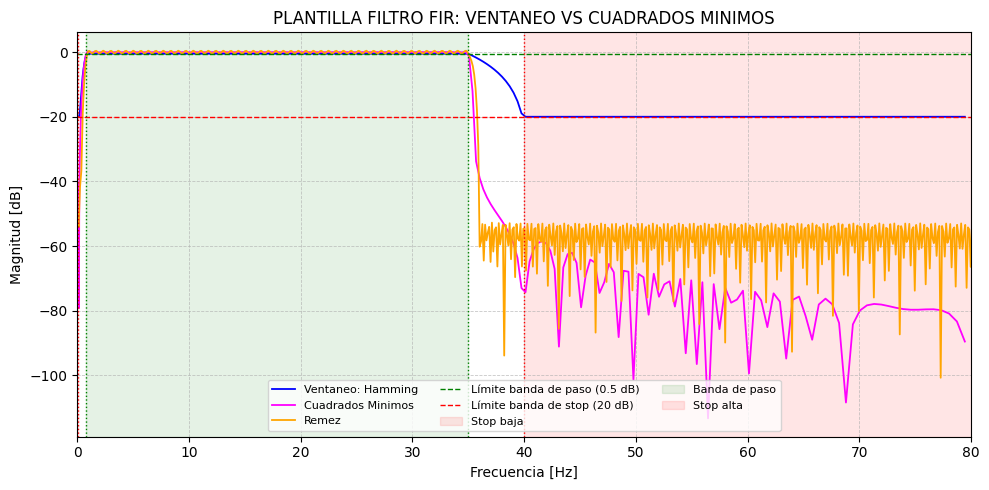

In [9]:
#%% VISUALIZACIÓN: FIR con plantilla de diseño
plt.figure(figsize=(10,5))
plt.plot(w_fir, h_fir_win_db, color='blue', linewidth=1.3, label='Ventaneo: Hamming')
plt.plot(w_ls, h_ls_db, color='magenta', linewidth=1.3, label='Cuadrados Minimos')
plt.plot(w_rz, h_rz_db, color='orange', linewidth=1.3, label='Remez')

plt.axhline(-ripple, color='green', linestyle='--', linewidth=1, label='Límite banda de paso (0.5 dB)')
plt.axhline(-atenuacion, color='red', linestyle='--', linewidth=1, label='Límite banda de stop (20 dB)')

plt.axvspan(0, ws1, color='red', alpha=0.1, label='Stop baja')
plt.axvspan(wp1, wp2, color='green', alpha=0.1, label='Banda de paso')
plt.axvspan(ws2, nyq, color='red', alpha=0.1, label='Stop alta')

plt.axvline(ws1, color='r', linestyle=':', linewidth=1)
plt.axvline(wp1, color='g', linestyle=':', linewidth=1)
plt.axvline(wp2, color='g', linestyle=':', linewidth=1)
plt.axvline(ws2, color='r', linestyle=':', linewidth=1)

plt.title('PLANTILLA FILTRO FIR: VENTANEO VS CUADRADOS MINIMOS')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('Magnitud [dB]')
plt.xlim(0, 80)
plt.grid(True, which='both', linestyle='--', linewidth=0.6, alpha=0.7)
plt.legend(loc='lower center', ncol=3, fontsize=8)
plt.tight_layout()
plt.show()

### FILTRADO DE ECG RUIDOSA:

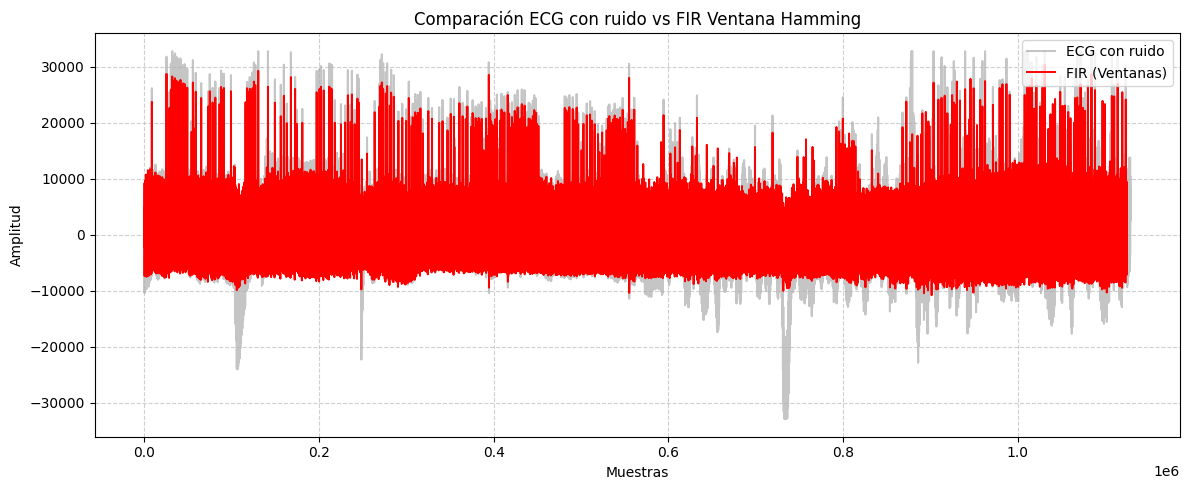

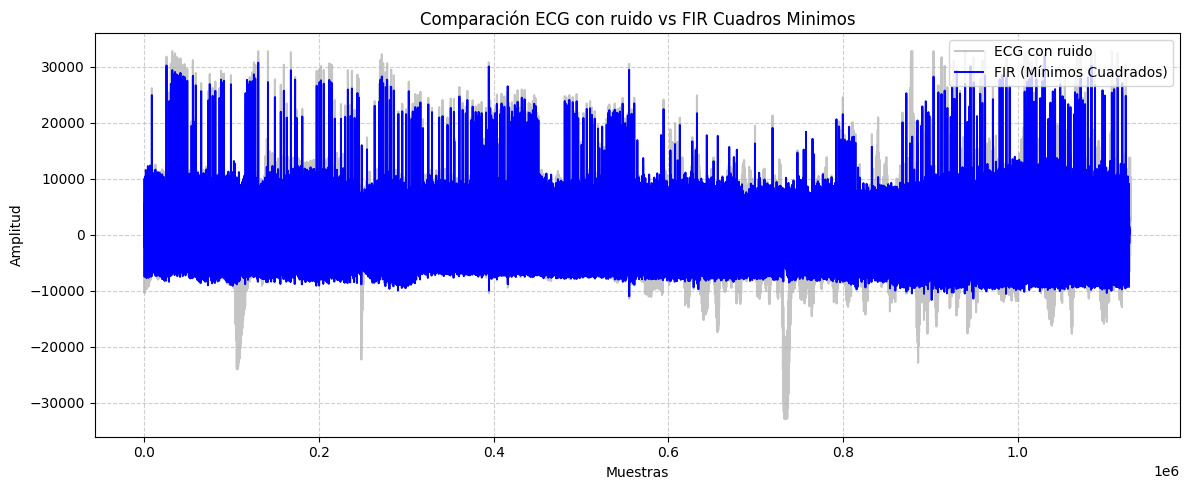

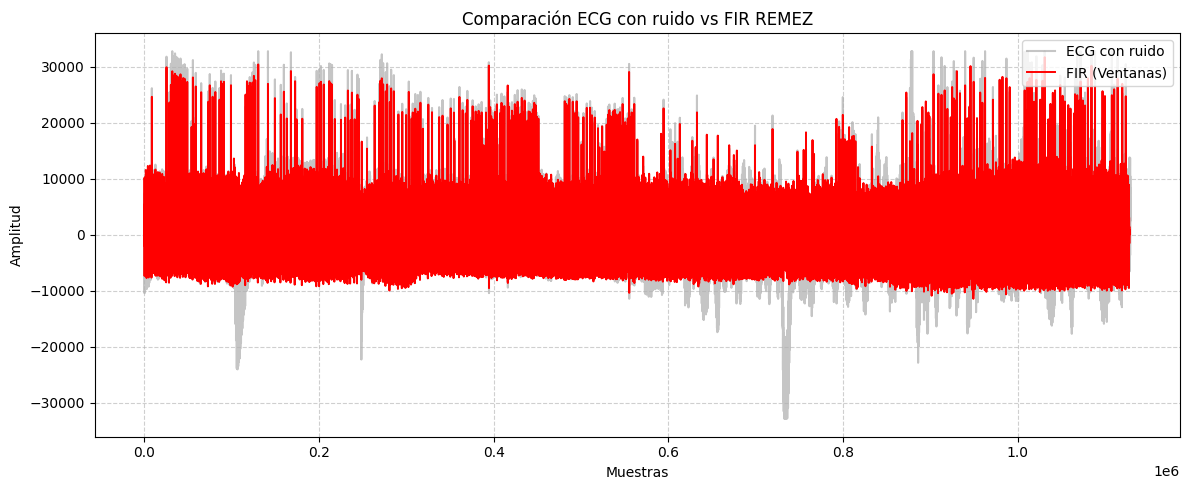

In [10]:
# COMPARACION FILTROS FIR: VENTANAS VS CUADRADOS MINIMOS

ecg_fir_ls = lfilter(b_fir_ls, 1.0, ecg_one_lead)
retardo_ls = (len(b_fir_ls) - 1) // 2

ecg_fir_win = lfilter(b_fir_win, 1.0, ecg_one_lead)
retardo_win = (len(b_fir_win) - 1) // 2

ecg_fir_remez = lfilter(fir_remez, 1.0, ecg_one_lead)
retardo_remez = (numtaps_remez-1)//2

#METODO VENTANEO:
plt.figure(figsize=(12,5))
plt.plot(ecg_one_lead, color='gray', alpha=0.45, label='ECG con ruido', zorder=1)
plt.plot(ecg_fir_win[retardo_win:], color='red', linewidth=1.4, label='FIR (Ventanas)', zorder=3)
plt.title('Comparación ECG con ruido vs FIR Ventana Hamming')
plt.xlabel('Muestras')
plt.ylabel('Amplitud')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(loc='upper right')
plt.tight_layout()

#CUADRADOS MINIMOS:
plt.figure(figsize=(12,5))
plt.plot(ecg_one_lead, color='gray', alpha=0.45, label='ECG con ruido', zorder=1)
plt.plot(ecg_fir_ls[retardo_ls:],  color='blue',  linewidth=1.4, label='FIR (Mínimos Cuadrados)', zorder=2)
plt.title('Comparación ECG con ruido vs FIR Cuadros Minimos')
plt.xlabel('Muestras')
plt.ylabel('Amplitud')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(loc='upper right')
plt.tight_layout()

#REMEZ:
plt.figure(figsize=(12,5))
plt.plot(ecg_one_lead, color='gray', alpha=0.45, label='ECG con ruido', zorder=1)
plt.plot(ecg_fir_remez[retardo_remez:], color='red', linewidth=1.4, label='FIR (Ventanas)', zorder=3)
plt.title('Comparación ECG con ruido vs FIR REMEZ')
plt.xlabel('Muestras')
plt.ylabel('Amplitud')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(loc='upper right')
plt.tight_layout()

plt.show()

Entre los tres métodos de diseño FIR analizados —Ventaneo (Hamming), Cuadrados Mínimos (firls) y Parks–McClellan (remez)— el rendimiento no es equivalente cuando se los aplica al filtrado de un ECG real.  
Aunque Remez ofrece la mayor selectividad teórica, su naturaleza equirriple introduce ondulaciones tanto en la banda pasante como en la banda de transición, lo que puede distorsionar amplitudes fisiológicas sensibles (ondas P y T). El método por Ventaneo, si bien estable y de fase casi lineal, depende directamente de la forma de la ventana, requiriendo órdenes mayores y mostrando atenuación y selectividad limitadas.

El método de **Cuadrados Mínimos** (firls) resulta el **más adecuado para este caso**:  
optimiza la respuesta en frecuencia minimizando el error promedio respecto de la plantilla del ECG, lo que se traduce en:

- menor ripple efectivo en la banda útil,  
- transiciones suaves sin oscilaciones indeseadas,  
- orden moderado con buena selectividad,  
- excelente preservación de la morfología del complejo QRS.  

Por estas razones, y **siguiendo los criterios expuestos en Holton** sobre el tratamiento de señales fisiológicas, el FIR diseñado mediante Cuadrados Mínimos ofrece el mejor compromiso entre **fidelidad temporal, estabilidad y atenuación del ruido** para este ECG en particular.

---

A continuación haremos una comparacion entre el mejor filtro de cada familia evaluando ciertas regiones de interes: 



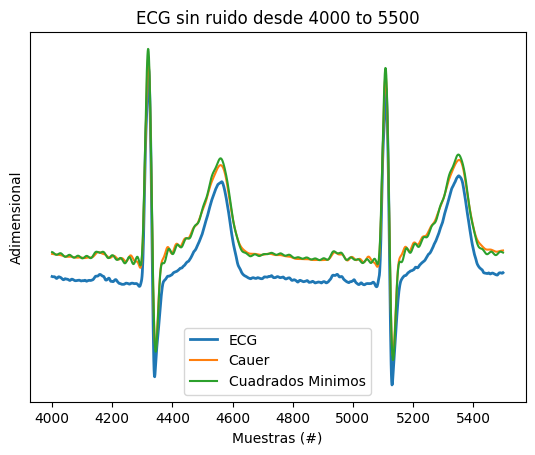

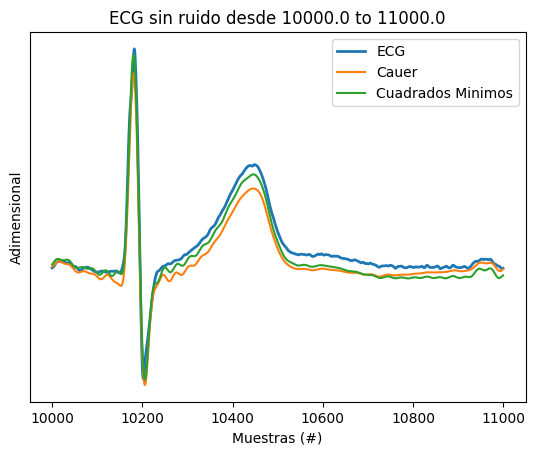

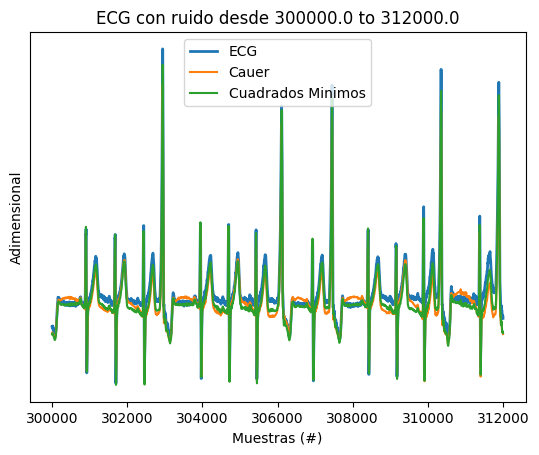

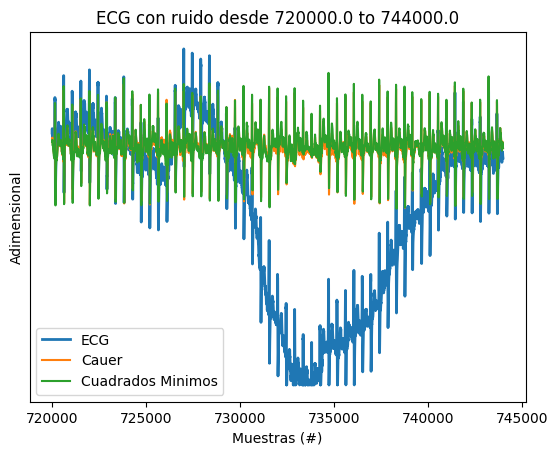

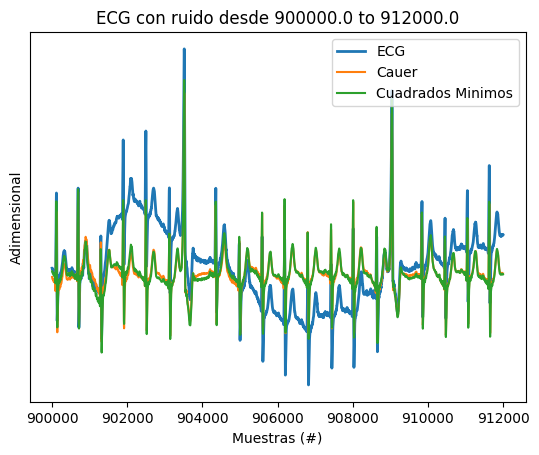

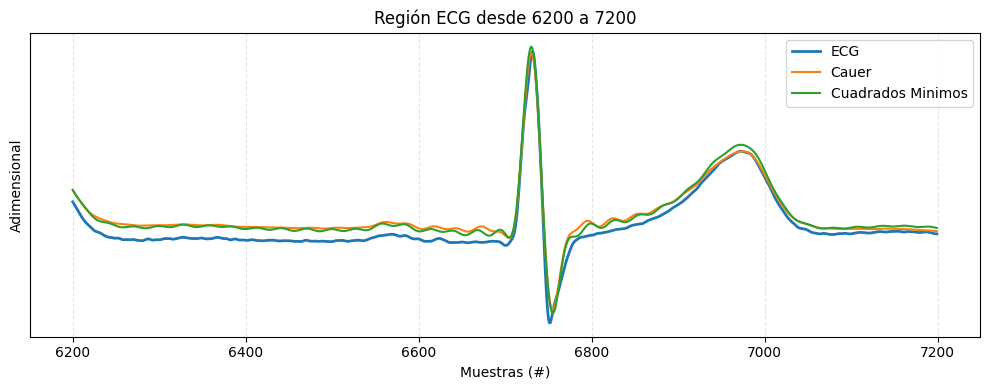

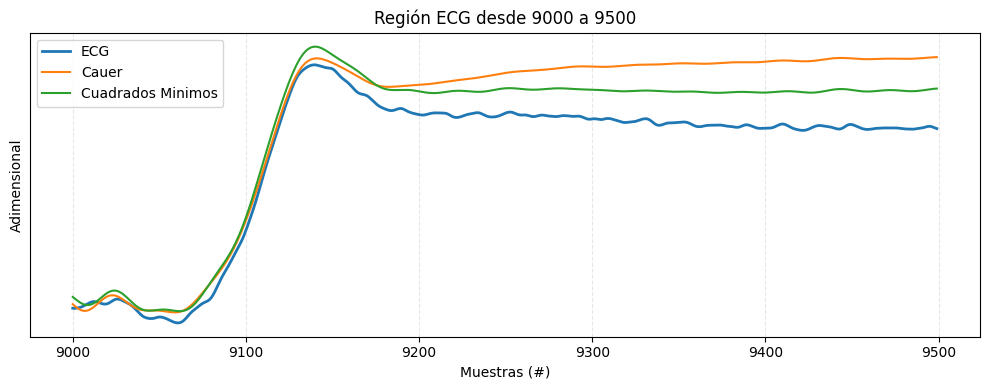

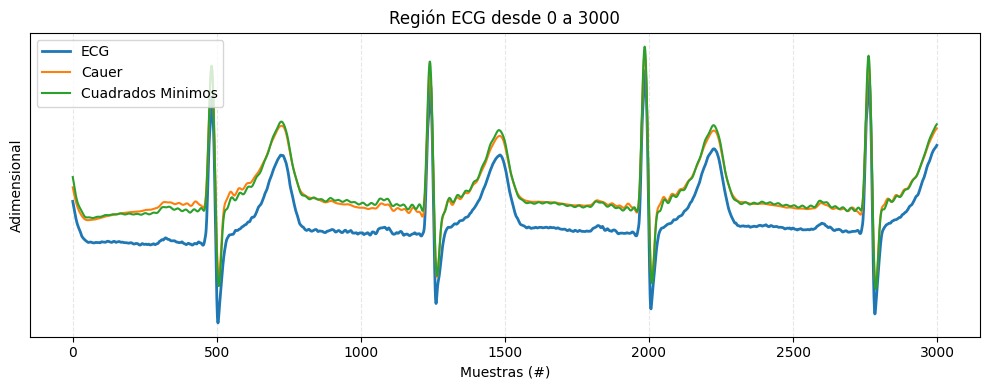

In [11]:
#################################
# Regiones de interés sin ruido #
#################################

cant_muestras = len(ecg_one_lead)

regs_interes = (
        [4000, 5500], # muestras
        [10e3, 11e3], # muestras
        )
 
for ii in regs_interes:
   
    # intervalo limitado de 0 a cant_muestras
    zoom_region = np.arange(np.max([0, ii[0]]), np.min([cant_muestras, ii[1]]), dtype='uint')
   
    plt.figure()
    plt.plot(zoom_region, ecg_one_lead[zoom_region], label='ECG', linewidth=2)
    plt.plot(zoom_region, ecg_filt_cauer[zoom_region], label='Cauer')
    plt.plot(zoom_region, ecg_fir_ls[zoom_region + retardo_ls], label='Cuadrados Minimos')
   
    plt.title('ECG sin ruido desde ' + str(ii[0]) + ' to ' + str(ii[1]) )
    plt.ylabel('Adimensional')
    plt.xlabel('Muestras (#)')
   
    axes_hdl = plt.gca()
    axes_hdl.legend()
    axes_hdl.set_yticks(())
           
    plt.show()
 
#################################
# Regiones de interés con ruido #
#################################
 
regs_interes = (
        np.array([5, 5.2]) *60*fs_ecg, # minutos a muestras
        np.array([12, 12.4]) *60*fs_ecg, # minutos a muestras
        np.array([15, 15.2]) *60*fs_ecg, # minutos a muestras
        )
 
for ii in regs_interes:
   
    # intervalo limitado de 0 a cant_muestras
    zoom_region = np.arange(np.max([0, ii[0]]), np.min([cant_muestras, ii[1]]), dtype='uint')
   
    plt.figure()
    plt.plot(zoom_region, ecg_one_lead[zoom_region], label='ECG', linewidth=2)
    plt.plot(zoom_region, ecg_filt_cauer[zoom_region], label='Cauer')
    plt.plot(zoom_region, ecg_fir_ls[zoom_region + retardo_ls], label='Cuadrados Minimos')
   
    plt.title('ECG con ruido desde ' + str(ii[0]) + ' to ' + str(ii[1]) )
    plt.ylabel('Adimensional')
    plt.xlabel('Muestras (#)')
   
    axes_hdl = plt.gca()
    axes_hdl.legend()
    axes_hdl.set_yticks(())
           
    plt.show()


# REGIONES DE INTERES EXTRA:

regs_interes_extra = (
    [6200, 7200],
    [9000, 9500],
    [0, 3000]
)

for ii in regs_interes_extra:

    zoom = np.arange(ii[0], ii[1], dtype='uint')

    plt.figure(figsize=(10,4))
    plt.plot(zoom, ecg_one_lead[zoom], label='ECG', linewidth=2)
    plt.plot(zoom, ecg_filt_cauer[zoom], label='Cauer')
    plt.plot(zoom, ecg_fir_ls[zoom + retardo_ls], label='Cuadrados Minimos')

    plt.title(f'Región ECG desde {ii[0]} a {ii[1]}')
    plt.ylabel('Adimensional')
    plt.xlabel('Muestras (#)')
    plt.legend()
    plt.gca().set_yticks(())
    plt.grid(True, linestyle='--', alpha=0.3)
    plt.tight_layout()
    plt.show()


# Regiones sin ruido del ECG
## Intervalo: **4000–5500 muestras**:

Esta región contiene latidos limpios, sin interferencias significativas. Es ideal para verificar si los filtros son **inocuos en la banda útil**, es decir, si no modifican la morfología fisiológica cuando no hay contaminación presente.

### Observaciones
- **Filtro Cauer**
  - Mantiene la forma del QRS prácticamente idéntica a la señal original.
  - No introduce ripple en la banda pasante.
  - Preserva amplitudes y pendientes.
  - Mantiene estable la línea isoeléctrica.

- **Filtro FIR por Cuadrados Mínimos**
  - Suaviza las pendientes rápidas del QRS.
  - Reduce levemente la amplitud pico-a-pico.
  - La onda T aparece más “redondeada”.
  - No introduce artefactos ni ripple.

> En regiones limpias, el **Cauer** preserva mejor la morfología fina; el **FIR-LS** suaviza automáticamente debido a su naturaleza de aproximación global.

## Intervalo: **10 000–11 000 muestras**:

Esta región presenta varios latidos consecutivos bien definidos. Es útil para evaluar continuidad temporal y estabilidad del filtrado.

### Observaciones
- **Filtro Cauer**
  - Reproduce correctamente la secuencia P–QRS–T.
  - No desplaza temporalmente las ondas gracias al filtrado bidireccional (`sosfiltfilt`).
  - Conservar la línea base sin deformaciones.

- **Filtro FIR por Cuadrados Mínimos**
  - Suaviza los flancos rápidos del QRS.
  - Aún así, sigue la morfología general de cada latido.
  - Amplitudes ligeramente reducidas

> Ambos filtros son correctos en ausencia de ruido, pero el **Cauer** mantiene las características diagnósticas sin pérdida de detalle.

## Conclusión para zonas sin ruido: 
En las **regiones sin ruido**, donde se evalúa la inocuidad del filtrado, el filtro **IIR Cauer** demostró la mejor preservación de la morfología cardíaca. Mantiene la forma del QRS, la onda T y la línea isoeléctrica prácticamente idénticas a la señal original.  
Los filtros FIR, especialmente el de **cuadrados mínimos**, mostraron un suavizado sistemático que, si bien no altera la estructura general, sí reduce pendientes y microdetalles clínicamente relevantes.

---

# Regiones con ruido del ECG

En esta sección se analiza el comportamiento de los filtros bajo diferentes niveles y tipos de ruido. Este análisis es crucial, ya que el propósito del filtrado no es solo limpiar la señal, sino hacerlo **sin deformar la fisiología del ECG**.

Las regiones evaluadas corresponden a segmentos donde se observan artefactos tales como:

- **Ruido muscular (EMG)** → alta frecuencia, aleatorio.
- **Movimiento de electrodos** → transitorios de media frecuencia.
- **Deriva de línea de base** → baja frecuencia.

## Intervalo: **300 000–312 000 muestras** (ruido moderado)  
Esta región presenta ruido muscular (alta frecuencia) superpuesto a la actividad eléctrica cardíaca.

### Observaciones
- **Cauer**
  - Atenúa de manera eficiente el ruido de alta frecuencia sin alterar la forma de los complejos QRS.
  - Mantiene la línea isoeléctrica estable.
  - Onda T estable y nítida.
    
- **FIR (Cuadrados Mínimos)**
  - Reduce bastante la energía de las pendientes del QRS.
  - Suaviza en exceso la onda T.
  - Sigue bien la forma pero con pérdida notoria de nitidez.

> En ruido moderado, el **Cauer** mantiene la forma cardíaca con claridad; el **FIR-LS** atenúa ruido pero sacrifica forma.

## Intervalo: **720 000–744 000 muestras** (ruido significativo)

En esta zona el ruido muscular y movimientos de los electrodos son más intensos, afectando varios ciclos cardíacos. Aquí se observa un gran defasaje de línea de base en la señal original.

### Observaciones
- **Cauer**
  - Mantiene un trazo estable y legible.
  - Aunque el ruido es fuerte, el QRS continúa identificable y con pendientes fisiológicas.
  - Rechaza completamente baseline wander.

    Baseline wander: es una oscilación de muy baja frecuencia provocada por respiración y movimiento, que desplaza el nivel isoeléctrico del ECG. El filtro Cauer logra eliminarla sin distorsionar la morfología del QRS, lo que resulta crítico para análisis clínicos.
    
- **FIR-LS**
  - También estabiliza la línea base, pero más lentamente.
  - Presenta una señal más suavizada y menos precisa.
  - Tiende a “aplanar” la información útil alrededor del mínimo en 733.000
    
> En artefactos de **movimiento**, el Cauer es claramente superior:controla baseline wander, preserva QRS y evita sobre-suavizado.


## Intervalo: **900 000–912 000 muestras** (ruido severo + saturaciones)

Este tramo incluye artefactos que superan ampliamente el nivel fisiológico, combinando ruido muscular y movimientos abruptos.

### Observaciones
- **Cauer**
  - Aun con ruido extremo, logra delinear QRS y ondas principales.
  - Atenúa pulsos de ruido de alta energía.
  - Permite identificar los ciclos cardíacos.
    
- **FIR-LS**
  - Colapsa severamente ante ruido alto.
  - Reduce amplitud del QRS.
  - “Aplana” la onda T y borra detalles.

> En ruido fuerte, el FIR-LS pierde la morfología casi por completo. El Cauer muestra una **robustez extraordinaria**.


## Conclusión para las regiones con ruido

En las **regiones con ruido**, tanto moderado como severo, la superioridad del filtro **Cauer** se hace aún más evidente. Este filtro:
- atenúa eficazmente el ruido muscular y el movimiento de electrodos,
- conserva amplitudes fisiológicas,
- mantiene el QRS nítido incluso ante artefactos abruptos,
- evita el sobre–suavizado característico de los FIR de orden elevado.

Por el contrario, el FIR por cuadrados mínimos, aunque atenúa el ruido, tiende a **aplanar** la señal conforme la interferencia aumenta, llegando incluso a degradar partes del QRS y la onda T en zonas muy contaminadas, perdiendo información fisiológica valiosa.

---
# Regiones extras del ECG

## Intervalo: **0–3000 muestras** (inicio del registro)

Esta región corresponde al comienzo del ECG, donde suelen aparecer microtransitorios, ajustes de electrodos y oscilaciones iniciales de línea de base.

### Observaciones
- **Cauer**
  - Estabiliza la línea de base de forma inmediata gracias a su transición muy abrupta.
  - Mantiene con claridad la forma del QRS desde los primeros latidos.
  - No introduce deformaciones perceptibles en las ondas P o T.
    
- **FIR-LS**
  - Estabiliza más lentamente.
  - Suavizado leve en QRS.
  - Onda T menos definida.

> Ambos funcionan bien, pero el Cauer se estabiliza más rápido y conserva mejor la morfología.


## Intervalo: **6200–7200 muestras** (ruido moderado tipico)

Zona con ruido muscular moderado y fluctuaciones rápidas, pero sin saturación extrema. Permite evaluar el desempeño real de cada filtro ante un nivel típico de interferencia.

### Observaciones
- **Cauer**
  - Elimina eficazmente el ruido de banda alta sin afectar la pendiente ascendente del QRS.
  - Conserva la amplitud relativa de las ondas P, QRS y T.
  - Mantiene el trazo firme y bien definido.
    
- **FIR-LS**
  - Suaviza bastante, especialmente en la pendiente ascendente.
  - El QRS pierde nitidez.
  - La T queda más redondeada.
    
> En ruido moderado, el Cauer mantiene mejor la forma cardíaca.

## Conclusion para regiones extras: 
Finalmente, en las **regiones extra** (inicio del registro, ruido moderado y transitorios abruptos), se observó nuevamente que:
- el **Cauer** preserva la morfología con excelente selectividad,
- el **FIR LS** responde bien solo en condiciones benignas, pero se vuelve inestable ante cambios bruscos,
- las transiciones abruptas del filtro IIR permiten una separación más eficiente entre banda útil y ruido sin necesidad de órdenes extremadamente altos.


## Intervalo: **9000–9500 muestras** (ruido abrupto y transitorios)

En esta zona aparecen picos abruptos de ruido muscular, pequeños desplazamientos de electrodos y variaciones de línea de base más marcadas. Es un escenario ideal para evaluar la robustez del filtrado.

### Observaciones
- **Cauer**
  - Atenúa casi por completo los transitorios de alta frecuencia.
  - Permite recuperar claramente la morfología del QRS aun en presencia de picos de ruido.
  - Mantiene la amplitud relativa del latido, sin compresión ni sobre-alisado.
- **FIR-LS**
  - El alto orden introduce arrastre del ruido.
  - Suaviza demasiado el QRS.
  - Aplana la T.

> El Cauer es nuevamente superior en presencia de transitorios abruptos.

## Conclusión para las regiones extras:

Finalmente, en las **regiones extra** (inicio del registro, ruido moderado y transitorios abruptos), se observó nuevamente que:
- el **Cauer** preserva la morfología con excelente selectividad,
- el **FIR LS** responde bien solo en condiciones benignas, pero se vuelve inestable ante cambios bruscos,
- las transiciones abruptas del filtro IIR permiten una separación más eficiente entre banda útil y ruido sin necesidad de órdenes extremadamente altos.

---
**Integrando todos los resultados**, la evidencia experimental concuerda plenamente con los criterios teóricos establecidos en Holton:  
> Para señales fisiológicas donde la morfología es fundamental y los contaminantes son significativos, los filtros IIR de tipo Cauer ofrecen el mejor compromiso entre selectividad, robustez y preservación temporal.

# **Conclusión Final: Comparación FIR vs IIR para el Procesamiento de ECG**

Existen tres pilares claves al diseñar filtros para señales fisiológicas:

1. **Conservación de la forma temporal**  
   Para señales donde la información está contenida en la **morfología** (QRS, ondas P y T), cualquier filtro que introduzca ripple o distorsión de fase debe ser considerado con precaución.

2. **Minimizar el ripple en banda pasante**  
   El ripple pasante altera directamente amplitudes diagnósticas.  
   Según Holton, los filtros aceptables para señales biomédicas deben tener:
   - pasabanda plana,
   - mínima ondulación,
   - **amplitud estable**, especialmente en frecuencias donde se concentra energía del QRS (5–20 Hz).

3. **Transiciones estrechas sin orden excesivo**  
   Holton demuestra que cuanto más estrecha la zona de transición, mayor el orden requerido (FIR) o mayor la selectividad (IIR).  
   En señales con ruido muscular (≈40–100 Hz), la selectividad es crítica.


A partir del análisis teórico, de las simulaciones implementadas y del comportamiento observado en distintas regiones del registro ECG, se establece la siguiente conclusión global sobre la elección entre filtros FIR e IIR.

## Comparación global: FIR vs IIR

### **Respuesta en frecuencia y selectividad**
- Los **filtros IIR** (especialmente Cauer y Chebyshev II) presentan **transiciones más abruptas**, permitiendo cumplir la plantilla del ECG con **órdenes significativamente menores**.
- Los **filtros FIR**, aun aplicando técnicas avanzadas (windowing, mínimos cuadrados o Remez), requieren **órdenes entre 2000–9000 coeficientes** para alcanzar la misma atenuación y ancho de banda de transición.

### **Preservación de morfología del ECG**
- Los **IIR de tipo Cauer y Chebyshev II** preservan adecuadamente la banda útil (0.8–35 Hz) sin agregar ripple en la pasabanda.
- Los **FIR LS** tienden a suavizar en exceso el QRS y las ondas T, especialmente en presencia de ruido moderado o fuerte.
- Los **FIR windowed** presentan menor distorsión que FIR-LS, pero tampoco alcanzan la nitidez que mantiene el Cauer.

### **Robustez frente al ruido**
- En ruido fuerte o abrupto, los **IIR Cauer** demostraron ser notablemente más robustos:
  - recuperan la morfología,
  - rechazan adecuadamente movimiento de electrodos y ruido muscular,
  - mantienen amplitud relativa.
- Los **FIR**, en estas mismas regiones, pierden energía del QRS y “aplanan” características clínicas clave.

### **Estabilidad y fase**
- FIR: fase lineal garantizada, siempre estables.
- IIR: requieren implementación **SOS + filtfilt** para evitar inestabilidad numérica o fase no lineal.
- En este trabajo, la combinación **(SOS + filtfilt)** permitió que los IIR operaran con **mínima distorsión temporal**, volviendo irrelevante la ventaja de fase lineal del FIR.

---

## **Conclusión general**

### Relación con los resultados experimentales del trabajo

Los resultados obtenidos coinciden plenamente con los principios expuestos por Holton:

| Propiedad | FIR Ventanas | FIR LS | Cheby1 | Cheby2 | Cauer |
|----------|--------------|--------|--------|--------|--------|
| Ripple pasabanda | Bajo | Muy bajo | Moderado | Nulo | Muy bajo |
| Selectividad | Media | Buena | Muy buena | Muy buena | Excelente |
| Preserva morfología | Correcto | Regular | Afectada | Muy buena | Excelente |
| Orden requerido | Muy alto | Muy alto | Bajo | Bajo | Mínimo |

**Conclusión apoyada en Holton:**  
> Para un ECG con fuerte contaminación de baja y alta frecuencia, la aproximación **elíptica (Cauer)** es la más adecuada, ya que mantiene la morfología crítica con el menor orden posible y con la mayor capacidad de separación entre banda útil y ruido.
> Según Holton, en aplicaciones donde el ancho de banda útil es acotado y el preservado de la forma de onda es esencial, los filtros IIR permiten lograr bandas bien delimitadas sin requerir órdenes elevados, lo que reduce el impacto del filtrado en la señal.

### **El filtro más adecuado para este ECG es el IIR Cauer.**

Ofrece:
- mejor selectividad,
- menor orden,
- excelente rechazo en ambas bandas de stop,
- preservación superior de la morfología,
- robustez frente a ruido real, no idealizado.

Los FIR siguen siendo apropiados cuando la **fase lineal exacta** es un requisito clínico innegociable, pero en este caso —donde se prioriza selectividad y robustez— los **IIR demostraron rendimiento claramente superior**.

Además, en **términos clínicos**, el IIR Cauer preservó de forma más fiel la morfología del QRS, lo cual es fundamental para los algoritmos de detección **de arritmias** y **análisis morfológico del electrocardiograma**.

---

## BONUS: 
Para el análisis adicional solicitado en el bonus, se incorporó una señal de voz grabada implementada en el trabajo practico anterior. El audio contiene la frase:

> *"Esta es una prueba para la práctica de estimación espectral"*

Este tipo de señal resulta interesante porque:
- La voz humana posee un contenido espectral bien definido entre **80–4000 Hz**, lo que permite estudiar armónicos, formantes y envolventes.
- Presenta un comportamiento claramente no estacionario.
- Permite evaluar cómo distintas ventanas modifican la estimación espectral (fundamental en el TP anterior).
- Es ideal para comparar métodos como Welch ó periodograma.

La señal se utilizó únicamente para estimación espectral, sin filtrado, y permite observar de forma clara cómo el contenido frecuencial cambia con el tiempo y según la técnica de análisis.



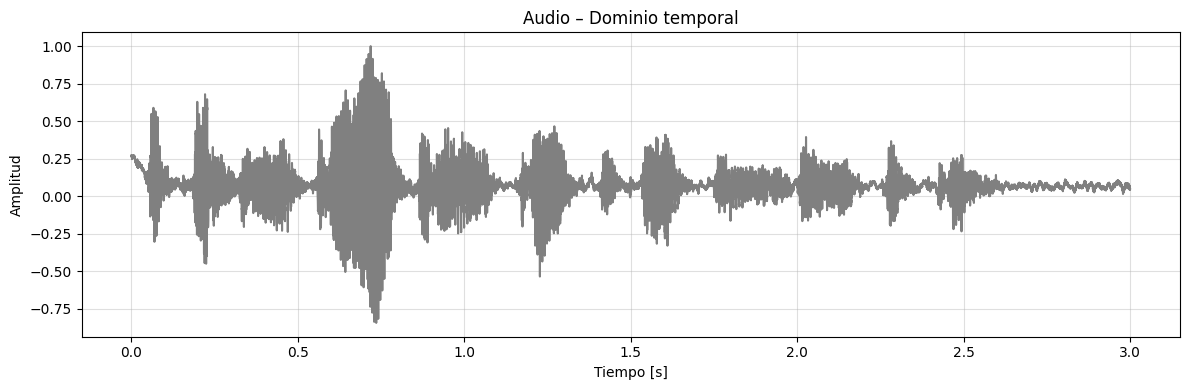

In [32]:
# Carga del archivo de audio

fs_audio, audio = wavfile.read('prueba psd.wav')

# Normalización si viene en enteros (int16)
if audio.dtype != float:
    audio = audio.astype(float) / np.max(np.abs(audio))

t = np.arange(len(audio)) / fs_audio

# Dominio temporal

plt.figure(figsize=(12,4))
plt.plot(t, audio, color='gray')
plt.title("Audio – Dominio temporal")
plt.xlabel("Tiempo [s]")
plt.ylabel("Amplitud")
plt.grid(True, alpha=0.4)
plt.tight_layout()
plt.show()

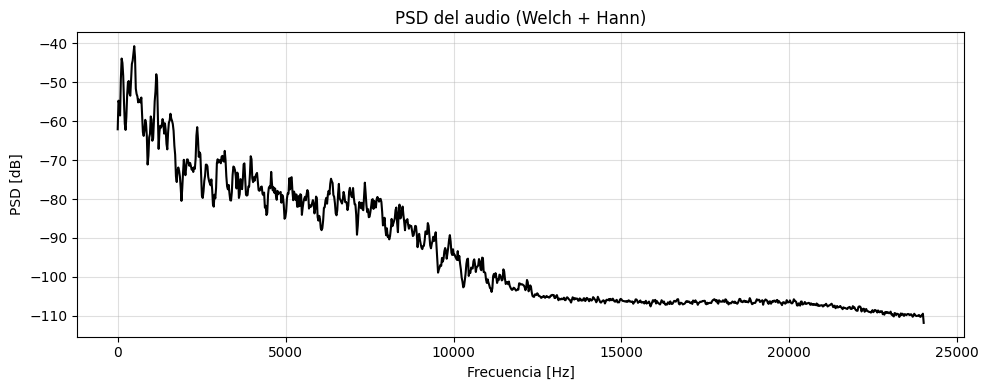

In [34]:
# PSD con Welch + ventana Hann 
f_psd, Pxx = welch(audio, fs_audio, window='hann', nperseg=2048)
Pxx_db = 10 * np.log10(Pxx + 1e-12)

plt.figure(figsize=(10,4))
plt.plot(f_psd, Pxx_db, color='k')
plt.title("PSD del audio (Welch + Hann)")
plt.xlabel("Frecuencia [Hz]")
plt.ylabel("PSD [dB]")
plt.grid(True, which='both', alpha=0.4)
plt.tight_layout()
plt.show()

A continuación procederemos a diseñar un filtro pasa-banda de la familia FIR e IIR donde la banda pasante sea: [80 - 5000] Hz, ya que la voz útil empieza aproximadamente en ese rango de frecuencias (masculinas). Así nos aseguramos de eliminar ruidos muy graves (vibraciones del micrófono, golpes, zumbido de red eléctrica en 50/60 Hz, viento fuerte) y ruidos agudos muy altos (silbidos, chasquidos, ruido electrónico, interferencias).

---

## FIR PASA BANDA [80-5000] PARA AUDIO:

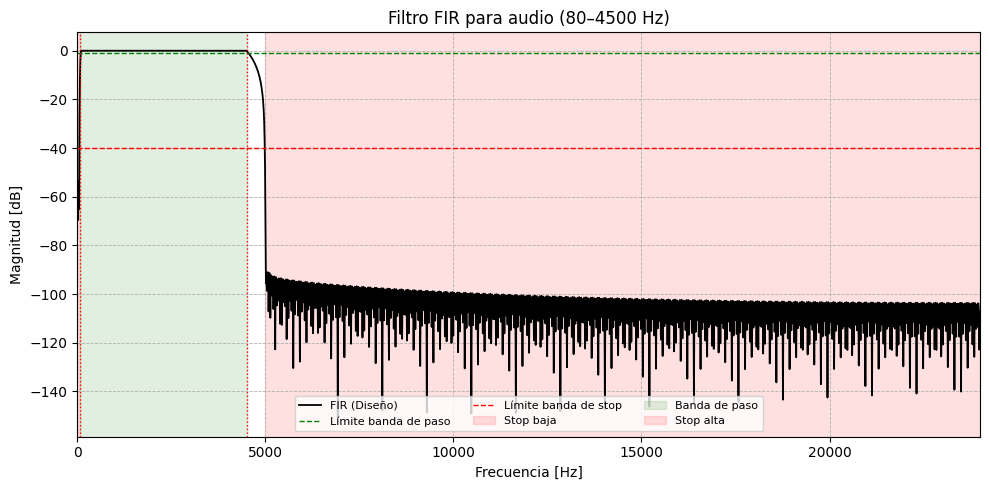

In [48]:
#%% 
# Frecuencias normalizadas
nyq = fs_audio/ 2
ws1_audio = 60
ws2_audio = 5000
wp1_audio = 80
wp2_audio = 4500

gpass, gstop = 1, 40

bands= np.array([0, ws1_audio+15, wp1_audio, wp2_audio, ws2_audio-15, nyq])/ nyq # plantilla
desired = [0, 0, 1, 1, 0, 0]

numtaps = 3001   # FIR largo → buena selectividad

firwin2_coeffs = firwin2(numtaps, bands, desired, window='hamming')

# Respuesta en frecuencia
w_fir2, h_fir2 = freqz(firwin2_coeffs, worN=2048, fs=fs_audio)
h_fir2_db = 20 * np.log10(np.abs(h_fir2) + 1e-12)

plt.figure(figsize=(10,5))
plt.plot(w_fir2, h_fir2_db, 'k', linewidth=1.3, label='FIR (Diseño)')

# ========= PLANTILLA DE DISEÑO =========
plt.axhline(-gpass, color='green', linestyle='--', linewidth=1,
            label='Límite banda de paso')
plt.axhline(-gstop, color='red', linestyle='--', linewidth=1,
            label='Límite banda de stop')

# ========= BANDAS (EN Hz) =========
plt.axvspan(0, ws1_audio, color='red', alpha=0.12, label='Stop baja')
plt.axvspan(wp1_audio, wp2_audio, color='green', alpha=0.12, label='Banda de paso')
plt.axvspan(ws2_audio, fs_audio/2, color='red', alpha=0.12, label='Stop alta')

# ========= LÍNEAS VERTICALES =========
plt.axvline(wp1_audio, color='r', linestyle=':', linewidth=1)
plt.axvline(wp2_audio, color='r', linestyle=':', linewidth=1)

plt.title('Filtro FIR para audio (80–4500 Hz)')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('Magnitud [dB]')
plt.xlim(0, fs_audio/2)
#plt.ylim(-120, 5)
plt.grid(True, which='both', linestyle='--', linewidth=0.6)
plt.legend(loc='lower center', ncol=3, fontsize=8)
plt.tight_layout()
plt.show()




---

## IIR BUTTERWORTH PASA BANDA [80-5000] PARA AUDIO:

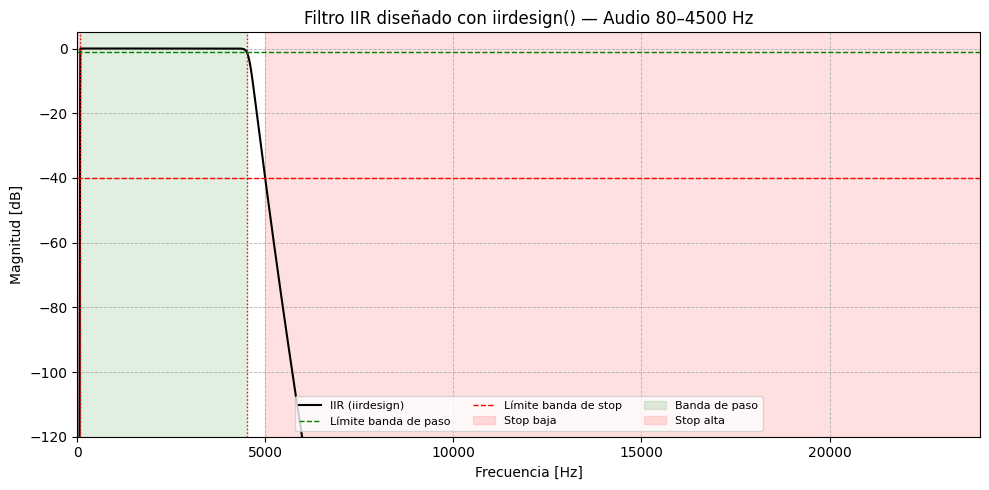

In [49]:
#%% 
# Diseño del filtro IIR con iirdesign
# Normalización
wp_audio = [wp1_audio/nyq, wp2_audio/nyq]
ws_audio = [ws1_audio/nyq, ws2_audio/nyq]

sos_iir_audio = iirdesign(
    wp=wp_audio,
    ws=ws_audio,
    gpass=gpass,
    gstop=gstop,
    ftype='butter',   # butter / cheby1 / cheby2 / ellip
    output='sos'
)

# Respuesta en frecuencia
w, h = freqz_sos(sos_iir_audio, worN=4096, fs=fs_audio)
h_db = 20 * np.log10(np.abs(h) + 1e-12)

plt.figure(figsize=(10,5))
plt.plot(w, h_db, linewidth=1.5, color='black', label='IIR (iirdesign)')


# ========= PLANTILLA DE DISEÑO =========
plt.axhline(-gpass, color='green', linestyle='--', linewidth=1,
            label='Límite banda de paso')
plt.axhline(-gstop, color='red', linestyle='--', linewidth=1,
            label='Límite banda de stop')

# ========= BANDAS (EN Hz) =========
plt.axvspan(0, ws1_audio, color='red', alpha=0.12, label='Stop baja')
plt.axvspan(wp1_audio, wp2_audio, color='green', alpha=0.12, label='Banda de paso')
plt.axvspan(ws2_audio, fs_audio/2, color='red', alpha=0.12, label='Stop alta')

# ========= LÍNEAS VERTICALES =========
plt.axvline(wp1_audio, color='r', linestyle=':', linewidth=1)
plt.axvline(wp2_audio, color='r', linestyle=':', linewidth=1)

plt.title('Filtro IIR diseñado con iirdesign() — Audio 80–4500 Hz')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('Magnitud [dB]')
plt.xlim(0, fs_audio/2)
plt.ylim(-120, 5)
plt.grid(True, which='both', linestyle='--', linewidth=0.6)
plt.legend(loc='lower center', ncol=3, fontsize=8)
plt.tight_layout()
plt.show()

---

## COMPARACION DE ESPECTROS FILTRADOS:

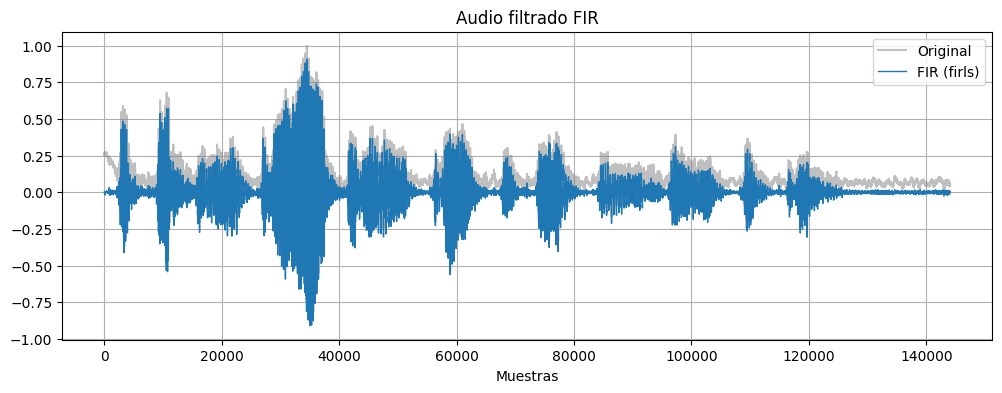

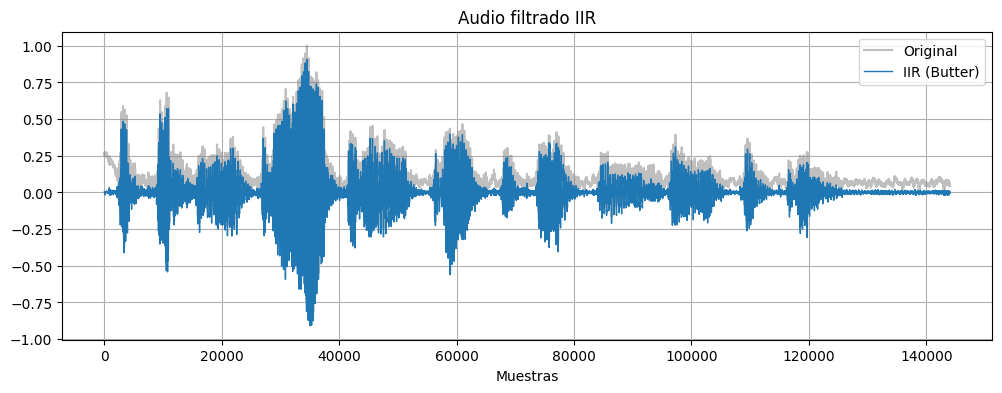

In [50]:
#%% 

# FIR 
audio_fir = filtfilt(firwin2_coeffs, 1.0, audio)

# IIR → filtfilt para no tener distorsión de fase
audio_iir = sosfiltfilt(sos_iir_audio, audio)

plt.figure(figsize=(12,4))
plt.plot(audio, color='gray', alpha=0.5, label="Original")
plt.plot(audio_fir, label="FIR (firls)", linewidth=1)
plt.legend()
plt.title("Audio filtrado FIR")
plt.xlabel("Muestras")
plt.grid(True)

plt.figure(figsize=(12,4))
plt.plot(audio, color='gray', alpha=0.5, label="Original")
plt.plot(audio_iir, label="IIR (Butter)", linewidth=1)
plt.legend()
plt.title("Audio filtrado IIR")
plt.xlabel("Muestras")
plt.grid(True)

plt.show()

In [55]:
#%% COMPARAMOS FILTRADOS ESCUCHANDO EL AUDIO:
    
import sounddevice as sd
import soundfile as sf

# --- Reproducir audio original ---
print("Reproduciendo audio original...")
sd.play(audio, fs_audio)
sd.wait()

# --- Reproducir audio FIR ---
print("Reproduciendo audio filtrado FIR...")
sd.play(audio_fir, fs_audio)
sd.wait()

# --- Reproducir audio IIR ---
print("Reproduciendo audio filtrado IIR...")
sd.play(audio_iir, fs_audio)
sd.wait()

#GUARDAMOS EL AUDIO:
    
#wavfile.write("audio_filtrado_IIR.wav", fs_audio, audio_iir.astype(np.float32))
#wavfile.write("audio_filtrado_FIR.wav", fs_audio, audio_fir.astype(np.float32))

Reproduciendo audio original...
Reproduciendo audio filtrado FIR...
Reproduciendo audio filtrado IIR...


Ambos filtros atenúan eficazmente:
- Las componentes de **baja frecuencia (< 80 Hz)**, normalmente asociadas a vibraciones o acoples del micrófono.
- Las **altas frecuencias (> 4500 Hz)**, típicamente ruido digital, fricción del aire o aliasing.

La inteligibilidad de la voz se conserva, lo cual confirma que el rango pasante elegido (80–4500 Hz) se ajusta de manera adecuada al contenido espectral útil del habla.

---

## Análisis del filtrado FIR (firwin2)

El filtro FIR diseñado con *firwin2* presenta:

### **Ventajas**
- **Fase estrictamente lineal**, preservando la forma temporal de las sílabas y transiciones rápidas.
- Excelente mantenimiento de la envolvente en las regiones formánticas principales (300–3000 Hz).
- No introduce resonancias ni artefactos perceptibles.

Esto queda en evidencia en la señal fitrada dado que:
- La señal resultante mantiene la misma estructura temporal que el audio original.
- La amplitud del habla no presenta overshoot ni ringing.
- El filtrado es perceptualmente “natural”.

### **Desventajas**
- Requiere **un número elevado de coeficientes** (3001 taps).
- Mayor costo computacional en tiempo real.
- Longitud elevada lo que lleva a una mayor transición temporal en bordes (mitigada con `filtfilt`).

---

## Análisis del filtrado IIR (iirdesign – Butterworth)

El filtro IIR, diseñado mediante `iirdesign()` con aproximación Butterworth, mostró:

### **Ventajas**
- **Alta selectividad** con un orden significativamente menor que el FIR.
- Muy buena supresión de energía fuera de banda, especialmente en regiones > 5 kHz.
- Implementación más eficiente computacionalmente.

Se puede observar en el grafico de la señal filtrada que:
- La energía residual fuera de banda disminuye drásticamente.
- La señal aparece ligeramente más “suavizada”.
- Las consonantes transitorias pierden un poco de nitidez (efecto típico de IIR aun con `filtfilt`).

### **Desventajas**
- La fase no es perfectamente lineal, lo que introduce pequeños desplazamientos o suavizados.
- Modifica la morfología temporal más que el FIR.

---

### ¿Por qué no se escuchan diferencias?

Porque la voz humana:
- Tiene su energía principal entre **100 y 4000 Hz**.
- No posee componentes significativas en 0–60 Hz ni por encima de 6 kHz en este audio en particular.
- El filtrado no elimina nada crucial para la inteligibilidad.

En otras palabras:
**Los filtros funcionan, pero el audio ya estaba en la banda correcta.**

Por eso, las diferencias —aunque presentes en los gráficos— **no generan cambios perceptibles en la escucha**, por esta razón, los filtros no llegan a eliminar información relevante sino
principalmente ruido en bajas y altas frecuencias donde el audio tenía poca
energía real. Auditivamente, el efecto es sutil y se percibe solo como un leve
“cerramiento” del sonido, típico de un pasabanda moderado (sensación de voz más
"cercana" debido a la atenuación de armónicos altos).

Estas diferencias, aunque visibles en los gráficos y cuantificables en la
respuesta en frecuencia, no generan un cambio perceptual significativo al momento de escucharlos 

Técnicamente, sin embargo, sí existen diferencias claras:

- El FIR presenta fase exactamente lineal y suaviza más los transitorios,
  produciendo una señal ligeramente más uniforme.
- El IIR conserva más energía en zonas de transición y es más eficiente, pero
  también más selectivo en la banda de rechazo, mostrando picos y caídas más
  marcadas en la respuesta en frecuencia.


| Aspecto | FIR (firwin2) | IIR (Butterworth) |
|--------|----------------|-------------------|
| Fase | Lineal | No lineal (corregida parcialmente con filtfilt) |
| Preservación de forma de onda | Excelente | Moderada |
| Selectividad | Alta (requiere gran orden) | Muy alta (bajo orden) |
| Costo computacional | Elevado | Bajo |
| Percepción subjetiva | Voz natural, fiel | Voz más “limpia” pero más suavizada |


## Conclusión técnica del Bonus

El filtrado FIR logra la mayor fidelidad temporal y mínima distorsión perceptual, lo cual lo hace adecuado cuando se desea preservar forma de onda (por ejemplo, análisis espectral fino o señales biomédicas).

El filtrado IIR es más eficiente y más agresivo suprimiendo ruido fuera de banda, pero introduce suavizado temporal y menor precisión en consonantes transitorias.

**Ambos métodos son válidos y útiles**, dependerá de las preferencias de implementacion del usuario. 
